<div align="center">
<a href="https://vbti.nl"><img src="./vbti_logo.png" width="400"></a>
</div>

# Classifying newsgroup postings

Classifying documents into 2 or more classes is useful for many applications, such as:

- filtering email spam
- sorting incoming messages according to their topic
- sentiment analysis
- sorting writings (e.g. books) according to their genre
- identifying the authors of documents

In this notebook you will develop a classifier to classify postings from the well known ['20 Newsgroups' dataset](http://qwone.com/~jason/20Newsgroups/). The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang, probably for his [Newsweeder: Learning to filter netnews paper](https://tinyurl.com/senr477).

Although the 20 Newsgroups data is part of the [Scikit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html?highlight=dataset#sklearn.datasets.fetch_20newsgroups) package, this notebook will start from the original file. This way, you will be confronted with all the details of processing and preparing a large number of files for a data science project.

## Content:
 - Preprocessing, downloading, and reading of the data
 - Cleaning
 - Visualizing the statistics of the data.
 - Feature engineering, visualizing the data.
 - Model building

In [1]:
# load some common libraries
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

## Download files

The first step is to download the ['20 Newsgroups' dataset](http://qwone.com/~jason/20Newsgroups/). Go to the website and download the file:

- 20news-bydate.tar.gz - 20 Newsgroups sorted by date; duplicates and some headers removed (18846 documents)

Uncompress the files (on linux use `tar xvzf 20news-bydate.tar.gz`).

In [4]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
        
def untar(fname, path):
    import tarfile
    
    my_tar = tarfile.open(fname)
    my_tar.extractall(path=path)
    my_tar.close() 

TAR_PATH = '20news-bydate.tar.gz'
URL = 'http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz' #big file test    

download_file(URL, TAR_PATH)

untar(TAR_PATH, '.')

File "20news-bydate.tar.gz" already exists. Skipping download.
File "." already exists. Skipping download.


## Reading files
Often data is stored in text files. To process this data in python, it needs to be read into the memory (we need it as a variable like `dataset`) from a file of this computer.

Below is an example of how to read a txt file in Python. You can change the `filename` and explore the files/postings from the 20 Newsgroups dataset. 

Notice that every posting starts with a header containing multiple lines such as 'From: ...' or 'Subject: ...'. Keeping the header information in the posting could have a bad influence on the model that will be trained later on. The objective is to train a model that learns to classify postings based on the *body content* of the posting. When header information is part of the training data, the model could rely on features form the header, such as names, dates, etc.

As the header and body text of a posting are seperated by an empty line, they can be easily split using the Python string method `partition()`.

In [5]:
# select a random file and show its content:
filename = './20news-bydate-train/alt.atheism/51155'

# read text (the original data uses latin1 file encoding)
with open(filename, 'r', encoding='latin1') as file_object:
    posting = file_object.read()    

# show text    
print(posting)

From: Nanci Ann Miller <nm0w+@andrew.cmu.edu>
Subject: Re: Dear Mr. Theist
Organization: Sponsored account, School of Computer Science, Carnegie Mellon, Pittsburgh, PA
Lines: 31
	<1993Apr5.024150.10193@wam.umd.edu>
NNTP-Posting-Host: po2.andrew.cmu.edu
In-Reply-To: <1993Apr5.024150.10193@wam.umd.edu>

west@next02cville.wam.umd.edu (Stilgar) writes:
> means to me.  The full quote (Michael Crichton, _Jurrasic_Park_) was 
> something like "The earth has existed quite contently for billions of 
> years.  We have been here but for the blink of an eye, and if we were gone
> tomorrow, the earth would not miss us.".  I remember this quote to keep
> myself humble when thinking that we have progressed so far or that we
> are masters of this planet.
  
Cool quote.

> The earth doesn't need saving, it's existed quite happily with-
> out us, we are the ones who need saving.

Better watch it.  The theists will jump on you for that... :-)

> Brian West.
> --
> THIS IS NOT A SIG FILE            *    -

In [6]:
# remove newsgroup header by splitting text at first empty line
_header, _blankline, body = posting.partition("\n\n")
body

'west@next02cville.wam.umd.edu (Stilgar) writes:\n> means to me.  The full quote (Michael Crichton, _Jurrasic_Park_) was \n> something like "The earth has existed quite contently for billions of \n> years.  We have been here but for the blink of an eye, and if we were gone\n> tomorrow, the earth would not miss us.".  I remember this quote to keep\n> myself humble when thinking that we have progressed so far or that we\n> are masters of this planet.\n  \nCool quote.\n\n> The earth doesn\'t need saving, it\'s existed quite happily with-\n> out us, we are the ones who need saving.\n\nBetter watch it.  The theists will jump on you for that... :-)\n\n> Brian West.\n> --\n> THIS IS NOT A SIG FILE            *    -"To the Earth, we have been\n> THIS IS NOT A SIG FILE            *     here but for the blink of an\n> OK, SO IT\'S A SIG FILE            *     eye, if we were gone tomorrow, \n> posted by west@wam.umd.edu        *     we would not be missed."-  \n> who doesn\'t care who knows it.  

Now that we know how to read a posting from file and remove the header, we define 2 functions that can be reused.

In [7]:
def get_newsgroup_body(text):
    return text.partition("\n\n")[2]

def read_newsgroup_text(filename, remove_header=True):
    with open(filename, 'r', encoding='latin1') as file_object:
        text = file_object.read()
    if remove_header:
        text = get_newsgroup_body(text)
    return text

## Scanning files in directories

In NLP project you often have to deal with a huge number of files organized in several folders. Each folder might contain samples of a specific class. To read all this data, we need to iterate over all subfolders.

In [8]:
import os

# set path to root of training data
path = './20news-bydate-train/'

# r=root, d=directories, f=files
for r, d, f in os.walk(path):
    i = 0
    for file in f:
        print(os.path.join(r, file), r)
        i += 1
        if i >= 2:
            # as there are many files, only show the first 2 file part subfolder
            break

./20news-bydate-train/alt.atheism\49960 ./20news-bydate-train/alt.atheism
./20news-bydate-train/alt.atheism\51060 ./20news-bydate-train/alt.atheism
./20news-bydate-train/comp.graphics\37261 ./20news-bydate-train/comp.graphics
./20news-bydate-train/comp.graphics\37913 ./20news-bydate-train/comp.graphics
./20news-bydate-train/comp.os.ms-windows.misc\10000 ./20news-bydate-train/comp.os.ms-windows.misc
./20news-bydate-train/comp.os.ms-windows.misc\10001 ./20news-bydate-train/comp.os.ms-windows.misc
./20news-bydate-train/comp.sys.ibm.pc.hardware\58343 ./20news-bydate-train/comp.sys.ibm.pc.hardware
./20news-bydate-train/comp.sys.ibm.pc.hardware\58826 ./20news-bydate-train/comp.sys.ibm.pc.hardware
./20news-bydate-train/comp.sys.mac.hardware\50418 ./20news-bydate-train/comp.sys.mac.hardware
./20news-bydate-train/comp.sys.mac.hardware\50419 ./20news-bydate-train/comp.sys.mac.hardware
./20news-bydate-train/comp.windows.x\64830 ./20news-bydate-train/comp.windows.x
./20news-bydate-train/comp.windo

## Parsing the datafiles
There are 20 subfolder, each storing the postings of a specific newsgroup.

The newsgroup name will be used as label of a posting in the dataset. Using Python's [regular expression module](https://www.w3schools.com/python/python_regex.asp) `re` we can easily get this label from the path.
Now, integrate scanning the subfolders routine with finding the label of a posting code.

In [9]:
import re

# define search pattern for last part of path string
pattern = r"[\w.-]+$"

# example path
path = "./20news-bydate-train/rec.autos"

# find pattern
re.findall(pattern, path)

['rec.autos']

In [10]:
import os

path = './20news-bydate-train/'

# r=root, d=directories, f=files
for r, d, f in os.walk(path):
    i = 0
    for file in f:
        print(os.path.join(r, file), re.findall(pattern, r)[0], file)
        i += 1
        if i >= 2:
            # as there are many files, only show the first 2 file part subfolder
            break

./20news-bydate-train/alt.atheism\49960 alt.atheism 49960
./20news-bydate-train/alt.atheism\51060 alt.atheism 51060
./20news-bydate-train/comp.graphics\37261 comp.graphics 37261
./20news-bydate-train/comp.graphics\37913 comp.graphics 37913
./20news-bydate-train/comp.os.ms-windows.misc\10000 comp.os.ms-windows.misc 10000
./20news-bydate-train/comp.os.ms-windows.misc\10001 comp.os.ms-windows.misc 10001
./20news-bydate-train/comp.sys.ibm.pc.hardware\58343 comp.sys.ibm.pc.hardware 58343
./20news-bydate-train/comp.sys.ibm.pc.hardware\58826 comp.sys.ibm.pc.hardware 58826
./20news-bydate-train/comp.sys.mac.hardware\50418 comp.sys.mac.hardware 50418
./20news-bydate-train/comp.sys.mac.hardware\50419 comp.sys.mac.hardware 50419
./20news-bydate-train/comp.windows.x\64830 comp.windows.x 64830
./20news-bydate-train/comp.windows.x\64831 comp.windows.x 64831
./20news-bydate-train/misc.forsale\70337 misc.forsale 70337
./20news-bydate-train/misc.forsale\74150 misc.forsale 74150
./20news-bydate-train/re

# Reading the data into memory
We can combine the code that reads individual postings and the code that scans directories to read all the files into memory.

In [8]:
import os
import re

path = './20news-bydate-train/'

ids = []
labels = []
postings = []

# r=root, d=directories, f=files
i = 0
for r, d, f in os.walk(path):
    for file in f:
        ids.append(file)                                             # store file id
        labels.append(re.findall(pattern, r)[0])                     # store posting label
        postings.append(read_newsgroup_text(os.path.join(r, file)))  # store posting body content
        
        # display process counter
        if i % 1000 == 0:
            print(f"doing {i} ...")
        i += 1
print(f"Read {i} postings.")
print("Ready.")

doing 0 ...
doing 1000 ...
doing 2000 ...
doing 3000 ...
doing 4000 ...
doing 5000 ...
doing 6000 ...
doing 7000 ...
doing 8000 ...
doing 9000 ...
doing 10000 ...
doing 11000 ...
Read 11314 postings.
Ready.


In [9]:
# Inspect data
i = 123
print("The index: {}".format(i))
print("The label: {}".format(labels[i]))
print("The posting: {}".format(postings[i]))

The index: 123
The label: talk.politics.mideast
The posting: 
Hossien Amehdi writes:


>In article <1993Apr15.160224.15940@unocal.com> stssdxb@st.unocal.com (Dorin Baru) writes:
>>>Now, about tough talk and arrogance, we are adults, aren't we ? Do you listen 
>>>to tough talk of american politicians ? or switch  the channel ? 


>I guess, I didn't make my point clear.  In the case of Israel government, it 
>is not only tough talk for its intimidation policy.  After all, not many
>people are intimidated just by talking.  Here how it goes: tough talks,
>followed by aggressive actions followed by taking pride of those actions and
>bragging about them.  >

Agressive actions are taken by both sides. Tough talk is done by both sides.
When an arab leader is menacing to throw all jews in the water is also tough talk,
I think. And killing people is mildly agressive (justified, in your opinion 
if they are israeli soldiers, justified, in others' opinion if they are jews, not
justified at all in 

## Cleaning text

To obtain a Bag-of-Words model, the posting text should consists of only words. Current, the posting text contains a lot of additional characters. Therefore, the posting text is processed to remove special characters, capitals, common words, and 1- and 2- letter words. So we are going to;

 1. Remove the symbols that are not letters.
 2. Convert all capital letters to lower case letters
 3. Remove stopwords (words like "is", "the" or "and") since these words do not carry any information. We will use the python package `nltk` for this task. 
 4. Remove all the words that only consist out of 1 or 2 letters.
 
The cells below first show how to do these whereafter a function is defined `clean_text` that combines everyting into one routine.

In [10]:
# 1.
import re

# index to posting
i=123

# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      postings[i] )          # The text to search
letters_only[0:100]

' Hossien Amehdi writes     In article      Apr                unocal com  stssdxb st unocal com  Dor'

In [11]:
lower_case = letters_only.lower()
words = lower_case.split()
words[:10]    # display first 10 words

['hossien',
 'amehdi',
 'writes',
 'in',
 'article',
 'apr',
 'unocal',
 'com',
 'stssdxb',
 'st']

In [14]:
!pip install nltk

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 1.5 MB 19.3 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449906 sha256=0784b3eab35ab460bf281a67fa7917f44852736b723de1497adb8e9bc6d4bd0b
  Stored in directory: /home/jovyan/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built nltk


In [17]:
import nltk
from nltk.corpus import stopwords # Import the stop word list
#stopwords.words("english") 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
words[:10]    # display first 10 words

['hossien',
 'amehdi',
 'writes',
 'article',
 'apr',
 'unocal',
 'com',
 'stssdxb',
 'st',
 'unocal']

In [19]:
# remove all words with 2 or 1 letters
words = [w for w in words if len(w)>2]
words[:10]    # display first 10 words

['hossien',
 'amehdi',
 'writes',
 'article',
 'apr',
 'unocal',
 'com',
 'stssdxb',
 'unocal',
 'com']

In [20]:
import re
from nltk.corpus import stopwords

def clean_text(s):
    # 1. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                          " ",                   # The pattern to replace it with
                          s )                    # The text to search

    # 2. Split into lower-case words
    lower_case = letters_only.lower()
    words = lower_case.split()
    
    # 3. Remove stop words
    # 4. Remove all words with 2 or 1 letters
    words = [w for w in words if (not w in stopwords.words("english")) and (len(w)>2)]
    
    # 5. Return words as a single string again
    return " ".join(words)

In [21]:
import os

def read_newsgroup_data(path):
    ids = []
    labels = []
    postings = []

    # r=root, d=directories, f=files
    i = 0
    for r, d, f in os.walk(path):
        for file in f:
            ids.append(file)
            labels.append(re.findall(pattern, r)[0])
            raw_text = read_newsgroup_text(os.path.join(r, file))
            postings.append(clean_text(raw_text))
            if i % 1000 == 0:
                print(f"doing {i} ...")
            i += 1
    print(f"Read {i} postings.")
    print("Ready.")
    return ids, labels, postings

In [22]:
# read training data
path = './20news-bydate-train/'
train_data = read_newsgroup_data(path)

doing 0 ...
doing 1000 ...
doing 2000 ...
doing 3000 ...
doing 4000 ...
doing 5000 ...
doing 6000 ...
doing 7000 ...
doing 8000 ...
doing 9000 ...
doing 10000 ...
doing 11000 ...
Read 11314 postings.
Ready.


In [23]:
# read test data
path = './20news-bydate-test/'
test_data = read_newsgroup_data(path)

doing 0 ...
doing 1000 ...
doing 2000 ...
doing 3000 ...
doing 4000 ...
doing 5000 ...
doing 6000 ...
doing 7000 ...
Read 7532 postings.
Ready.


# Best practices, serialzing with `pickle`
As you might notice, reading and cleaning the text files takes a long time. In production environments you would like to parallellize the complete task. For now, we are going to save the python tuples `train_data` and `test_data` into a Python pickle object. Python's `pickle` module is used to (de)serialize python objects to file. This way, objects can be shared between different Python programs and/or time is saved to create an object as in our case. A nice tutorial on using the pickle module can be found [here](https://www.datacamp.com/community/tutorials/pickle-python-tutorial).

In [24]:
import pickle

filename = './train_data.pickle'
with open(filename, 'wb') as file_object:
    pickle.dump(train_data, file_object)
    
filename = './test_data.pickle'
with open(filename, 'wb') as file_object:
    pickle.dump(test_data, file_object)    

In [27]:
# read pickle files
import pickle

filename = './train_data.pickle'
with open(filename, 'rb') as file_object:
    train_data = pickle.load(file_object)
    
filename = './test_data.pickle'
with open(filename, 'rb') as file_object:
    test_data = pickle.load(file_object)    

# EDA
It is a good practise to inspect how well the dataset is balanced. Imbalanced datasets might impact the performance of your model (since the machine learning models learn by example and, if a certain model has seen more examples of one specific class it becomes biased towards this class). Therefore, below is a histogram of the labels of your train and test dataset.

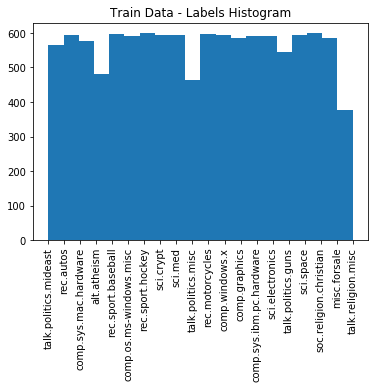

In [28]:
plt.hist(train_data[1], bins=20)
plt.xticks(rotation='vertical')
plt.title('Train Data - Labels Histogram');

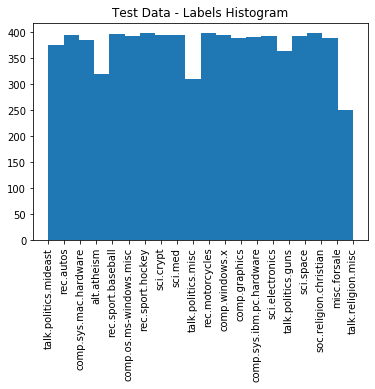

In [29]:
plt.hist(test_data[1], bins=20)
plt.xticks(rotation='vertical')
plt.title('Test Data - Labels Histogram');

# Feature engineering

## Bag of Words
When the text is cleaned we can start engineering our features. We start with the Bag-of-Words features. These features can calculated using [scikit-learn's bag of words tool](https://scikit-learn.org/stable/modules/feature_extraction.html?highlight=bag%20words).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer object
vectorizer = CountVectorizer(analyzer     = "word",   \
                             tokenizer    = None,    \
                             preprocessor = None, \
                             stop_words   = None,   \
                             max_features = 5_000) 

# Use the training dataset to fit the vectorizer. Next, transform the data.
# Both steps can be done in the 'fit_transform' method.
train_data_features = vectorizer.fit_transform(train_data[2])

# Convert to numpy array for convience
train_data_features = train_data_features.toarray()

In [32]:
# print size of train data
train_data_features.shape

(11314, 5000)

In [33]:
# print names of features
vocab = vectorizer.get_feature_names()
vocab[:10]   # print first 10 names

['aaa',
 'aaron',
 'abc',
 'abiding',
 'ability',
 'able',
 'abortion',
 'abs',
 'absolute',
 'absolutely']

# Visualizing the features
To get some insight into which features were selected by the BoW model, we plot a histogram of the word occurancies. First, we count the number of occurances per word and sort the list. Next, we plot a bar plot of the first 100 words.

In [34]:
# plot histogram of features showing how often specific words occur
features = []

# Sum up the counts of each vocabulary word
counts = np.sum(train_data_features, axis=0)

for feature_name, count in zip(vocab, counts):
    features.append((count, feature_name))
    
features.sort(key=lambda x:x[0], reverse=True)
features[:10]   # plot first 10 items

[(12290, 'edu'),
 (8977, 'one'),
 (8884, 'would'),
 (7844, 'writes'),
 (7499, 'com'),
 (6747, 'article'),
 (5914, 'people'),
 (5774, 'like'),
 (5088, 'know'),
 (4935, 'get')]

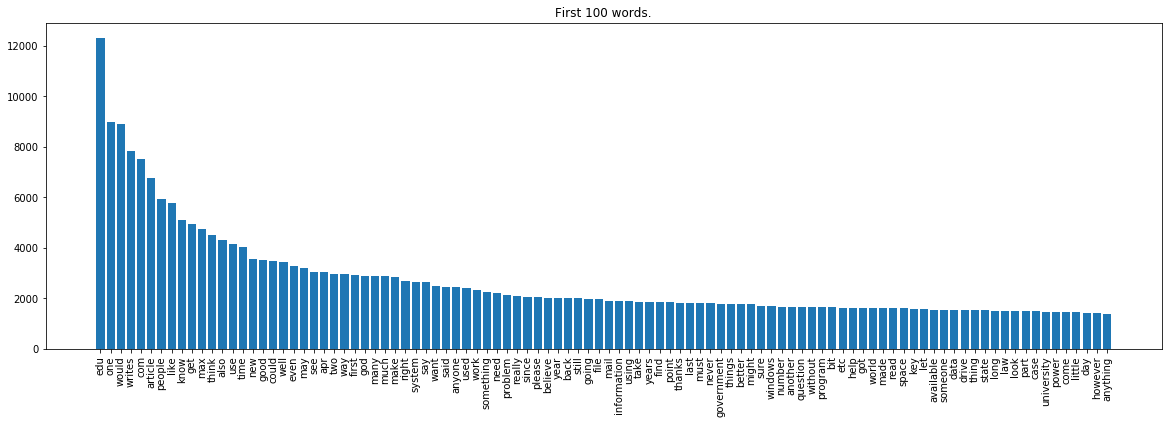

In [35]:
n = 100 # number of words to plot

# transform data structure for plotting
labels = [features[i][1] for i in range(n)]
counts = [features[i][0] for i in range(n)]

plt.figure(figsize=(20,6))
plt.bar(labels, counts)
plt.xticks(range(n), labels, rotation='vertical')
plt.title(f'First {n} words.');

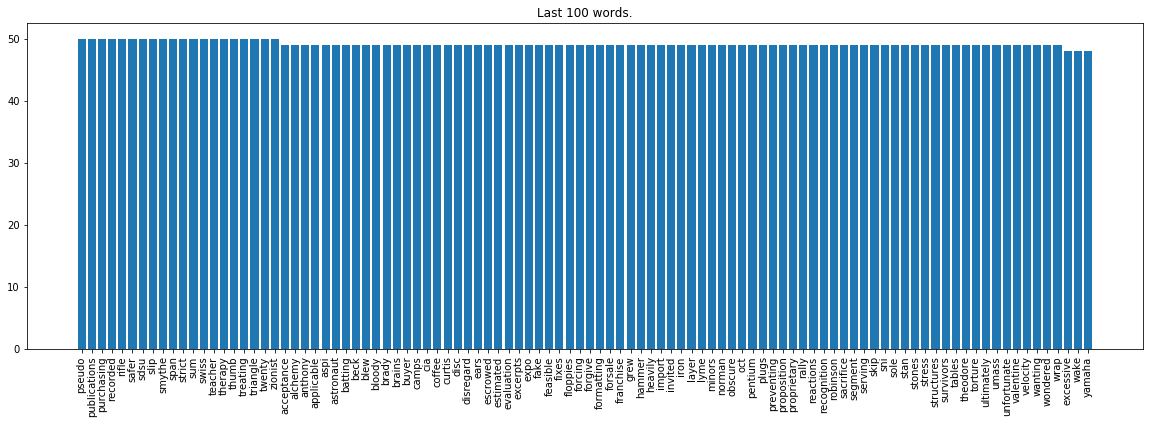

In [36]:
n = 100 # number of words to plot

# transform data structure for plotting
labels = [features[-i][1] for i in range(n,0,-1)]
counts = [features[-i][0] for i in range(n,0,-1)]

plt.figure(figsize=(20,6))
plt.bar(labels, counts)
plt.xticks(range(n), labels, rotation='vertical');
plt.title(f'Last {n} words.');

# Some remarks
At this point you might be tempted to update the `clean_text()` method. Words like 'edu', 'one' or 'would' occur many times and seem to be general terms that are used in the text of postings from any newsgroup. For now, we continue with the current BoW model as the goal is to create a first complete data processing pipeline and a baseline performence.

The features of the test dataset also need to be computed. Note that this time you need to use `transform()` method of the vectorizer object, as we don't want to refit the vectorizer!! The BoW model (vectorizer) is trained on the training data and than tested using the test data.

In [40]:
test_data_features = vectorizer.transform(test_data[2])
test_data_features = test_data_features.toarray()

## Transform text labels into integers

Most machine learning models only operate on numbers. The labels of our datasets are still strings with the newsgroup name. Now we will transform them into integers. Although tools like Pandas have functions to carry out this task, we are going to do it directly in Python for educational purpose.

In [41]:
# learn a newsgroup name - integer index table
train_labels_num = []

label_names = {}
i = 0
for l in train_data[1]:
    if l not in label_names:
        # add new labels to table (dictionary)
        label_names[l] = i
        i += 1
    train_labels_num.append(label_names[l])
    
label_names

{'talk.politics.mideast': 0,
 'rec.autos': 1,
 'comp.sys.mac.hardware': 2,
 'alt.atheism': 3,
 'rec.sport.baseball': 4,
 'comp.os.ms-windows.misc': 5,
 'rec.sport.hockey': 6,
 'sci.crypt': 7,
 'sci.med': 8,
 'talk.politics.misc': 9,
 'rec.motorcycles': 10,
 'comp.windows.x': 11,
 'comp.graphics': 12,
 'comp.sys.ibm.pc.hardware': 13,
 'sci.electronics': 14,
 'talk.politics.guns': 15,
 'sci.space': 16,
 'soc.religion.christian': 17,
 'misc.forsale': 18,
 'talk.religion.misc': 19}

In [42]:
# generate numerical labels for test set
test_labels_num = []

for l in test_data[1]:
    if l not in label_names:
        print("Error: unknown label!")
        break
    test_labels_num.append(label_names[l])

In [43]:
# create datasets (numpy arrays) for machine learning
X_train, y_train = train_data_features, np.array(train_labels_num)
X_test, y_test = test_data_features, np.array(test_labels_num)

Finally, the train dataset is sorted by the newsgroup label. As this might influence the learning of some machine learning models, the training dataset will be shuffled randomly.

In [44]:
# create random index
idx = np.arange(len(y_train), dtype=np.int)
np.random.shuffle(idx)

# reshuffle data
X_train = X_train[idx]
y_train = y_train[idx]

Before using the prepared data, a final visualization is made. Newsgroup postings can be classified if there are words (or word combinations) that are unique to a specific news group. TO get an impression of the uniqueness of words per newsgroup, we plot a random selection of words from our vocabulary and plot per newsgroup how often this words occurs. That is, we normalize the counts per word over all newsgroups.

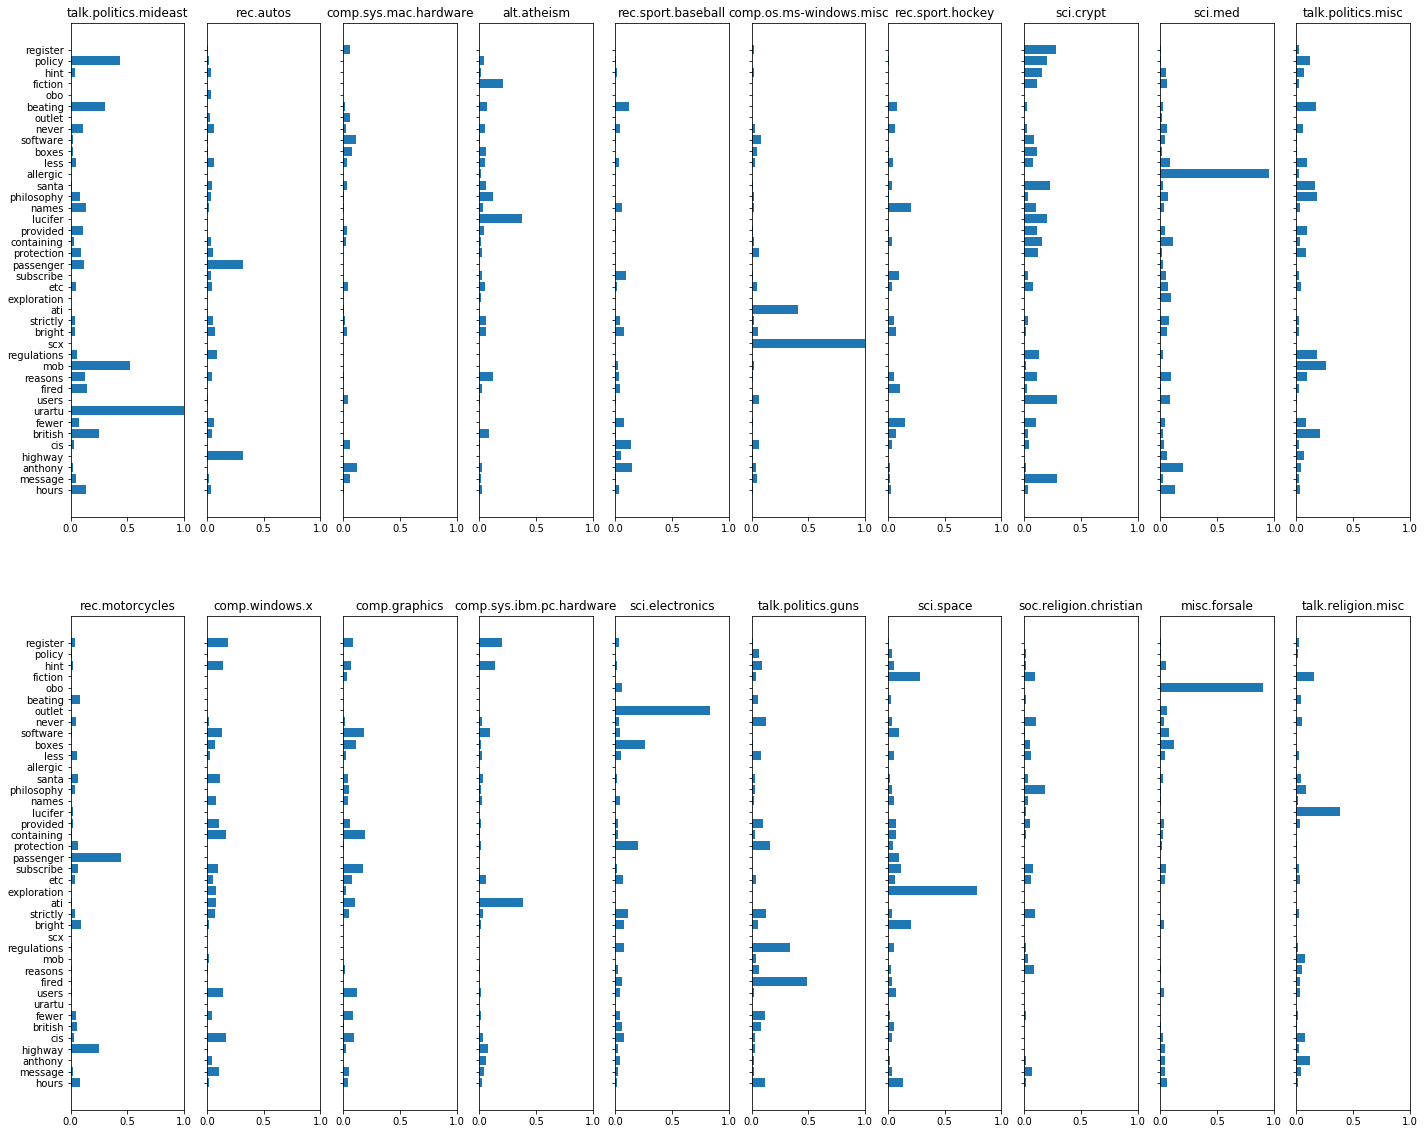

In [45]:
# refresh this Jupyter cell to plot a new random selection of words

N = 40 # number of words to plot

# select at random N words to plot
vocab_range = np.arange(len(vocab))
np.random.shuffle(vocab_range)
selected_words = vocab_range[0:N]

# calculate statisics
n_labels = len(label_names)
word_counts = np.zeros((N, n_labels))
for n in range(n_labels):
    idx = (y_train==n)
    word_counts[:,n] = X_train[:,selected_words][idx].sum(axis=0)
normalized_word_counts = word_counts / word_counts.sum(axis=1)[:,np.newaxis]

fig, axs = plt.subplots(2, n_labels//2, figsize=(24,20), sharey=True)

axs = axs.ravel()
for n in range(n_labels):
    axs[n].barh([vocab[i] for i in selected_words][::-1], normalized_word_counts[:,n][::-1])
    axs[n].set_title(list(label_names.keys())[n])
    axs[n].set_xlim([0,1])

# Model building
In this section we will train and compare the following models;
 - Random forest classifier
 - Naive bayes classifier
 - Td-IDF
 - SVM
Wereafter we will train models with as input an embedding of the posting instead of a bag of word models such that we can compare the bag-of-words with the embedding.

In [46]:
# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax==None:
        _, ax = plt.subplot(1, 1, figsize=figsize)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, pad=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')    
    ax.set_ylim((len(classes) - 0.5, -0.5))

    
def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_model_performance(model, X_train, y_train, X_test, y_test, label_names, figsize=(14,20)):
    """Support function for quickly plotting model performance."""
    fig, axs = plt.subplots(2, 1, figsize=figsize)

    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, 
                          list(label_names), 
                          title='Training - accuracy: {:.2f}'.format(accuracy(y_train, y_train_pred)),
                          ax=axs[0])

    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, 
                          list(label_names), 
                          title='Test - accuracy: {:.2f}'.format(accuracy(y_test, y_test_pred)),
                          ax=axs[1])

    plt.tight_layout()    

## RandomForest classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
model = RandomForestClassifier(n_estimators = 100, max_depth=100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
model = model.fit( X_train, y_train )

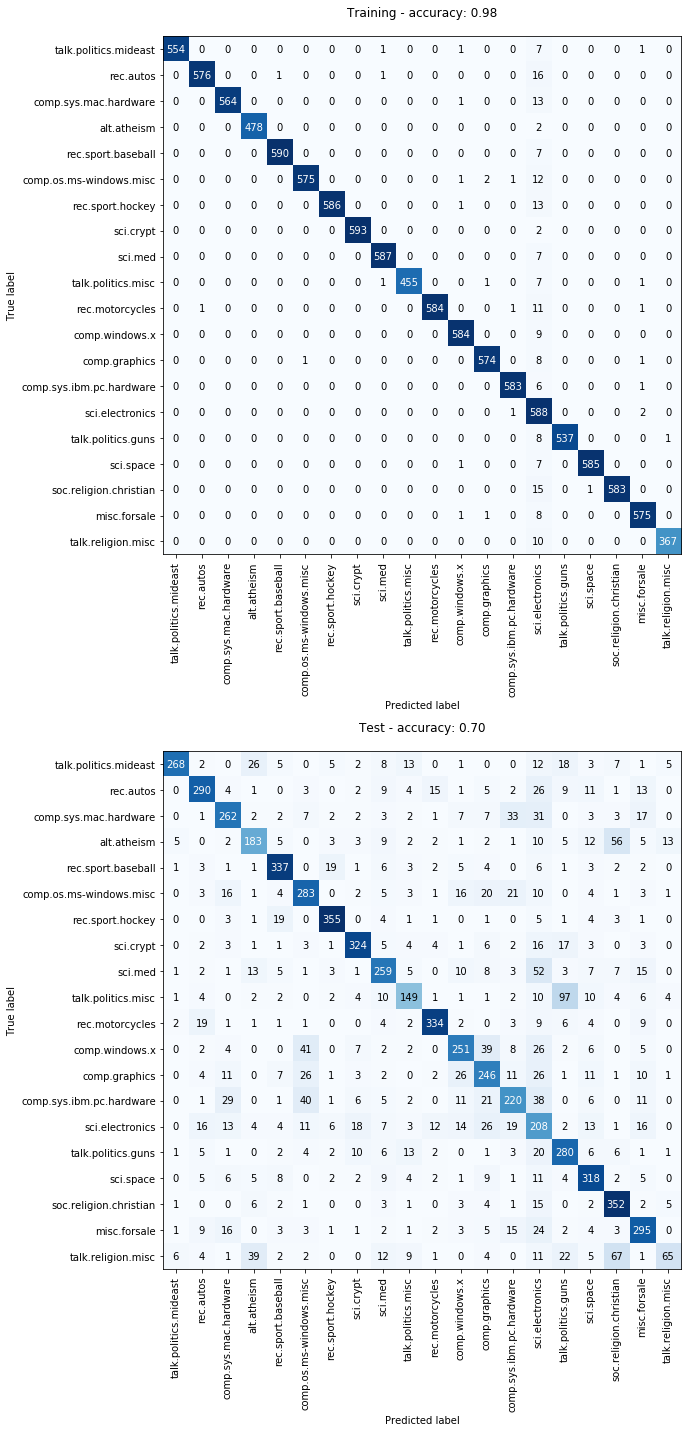

In [48]:
plot_model_performance(model, X_train, y_train, X_test, y_test, label_names)

## Naive Bayes classifier

In [49]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

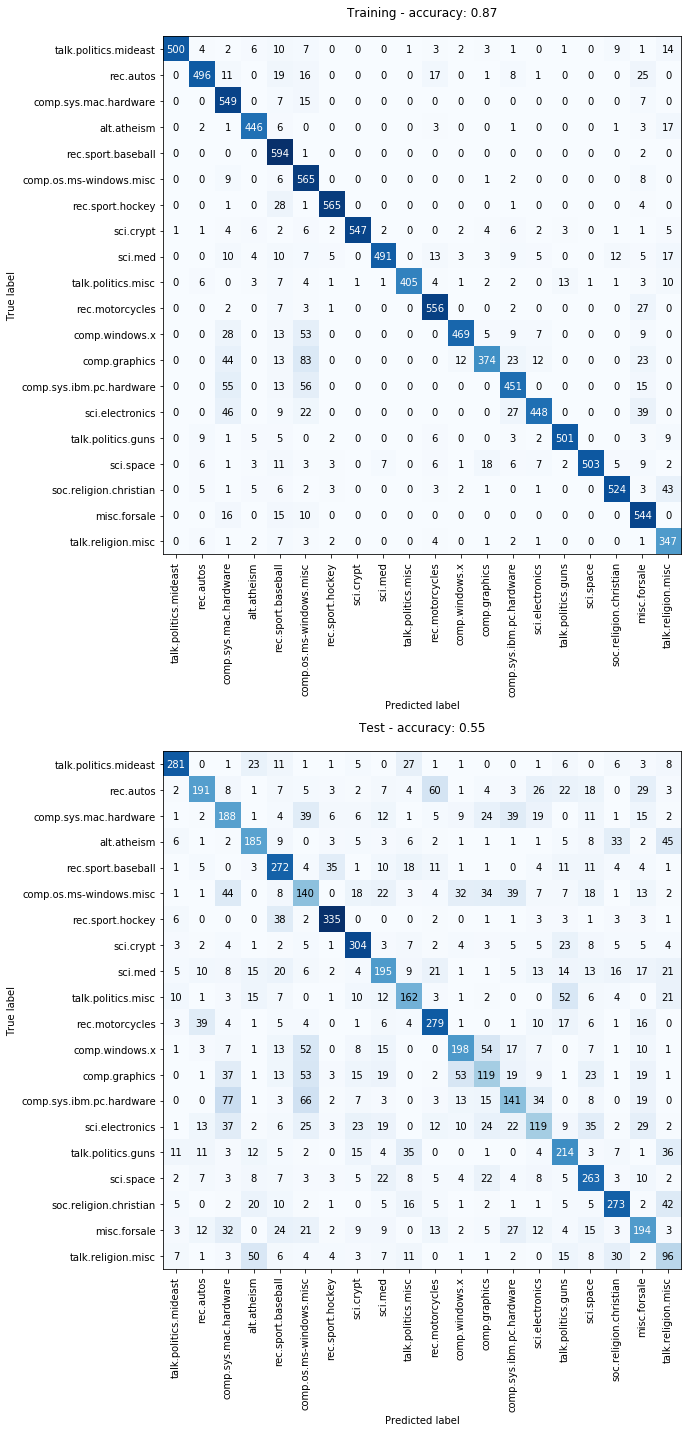

In [50]:
plot_model_performance(model, X_train, y_train, X_test, y_test, label_names)

# TF-IDF

Whereas Bag-of-Words counts the number of times a word occurs in a document, the *term frequency - inverse document frequency (TF-IDF)* normalizes the word counts and divides it by the number of documents it appears in.

$$\text{bow}(w, d) = \text{#times word } w \text{ appears in document } d$$

$$\text{tf-idf}(w, d) = \frac{\text{bow}(w, d) \cdot N}{\text{#times of documents in which word } w \text{ appears}}$$


In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
train_data_tfidf = tfidf.fit_transform(train_data_features).toarray()

In [52]:
train_data_tfidf.shape

(11314, 5000)

In [53]:
test_data_tfidf = tfidf.transform(test_data_features).toarray()

In [54]:
# create datasets (numpy arrays) for machine learning
X_train, y_train = train_data_tfidf, np.array(train_labels_num)
X_test, y_test = test_data_tfidf, np.array(test_labels_num)

In [55]:
# create random index
idx = np.arange(len(y_train), dtype=np.int)
np.random.shuffle(idx)

# reshuffle data
X_train = X_train[idx]
y_train = y_train[idx]

## Support Vector Machine trained with Stochastic Gradient Descent

In [56]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter=100)
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

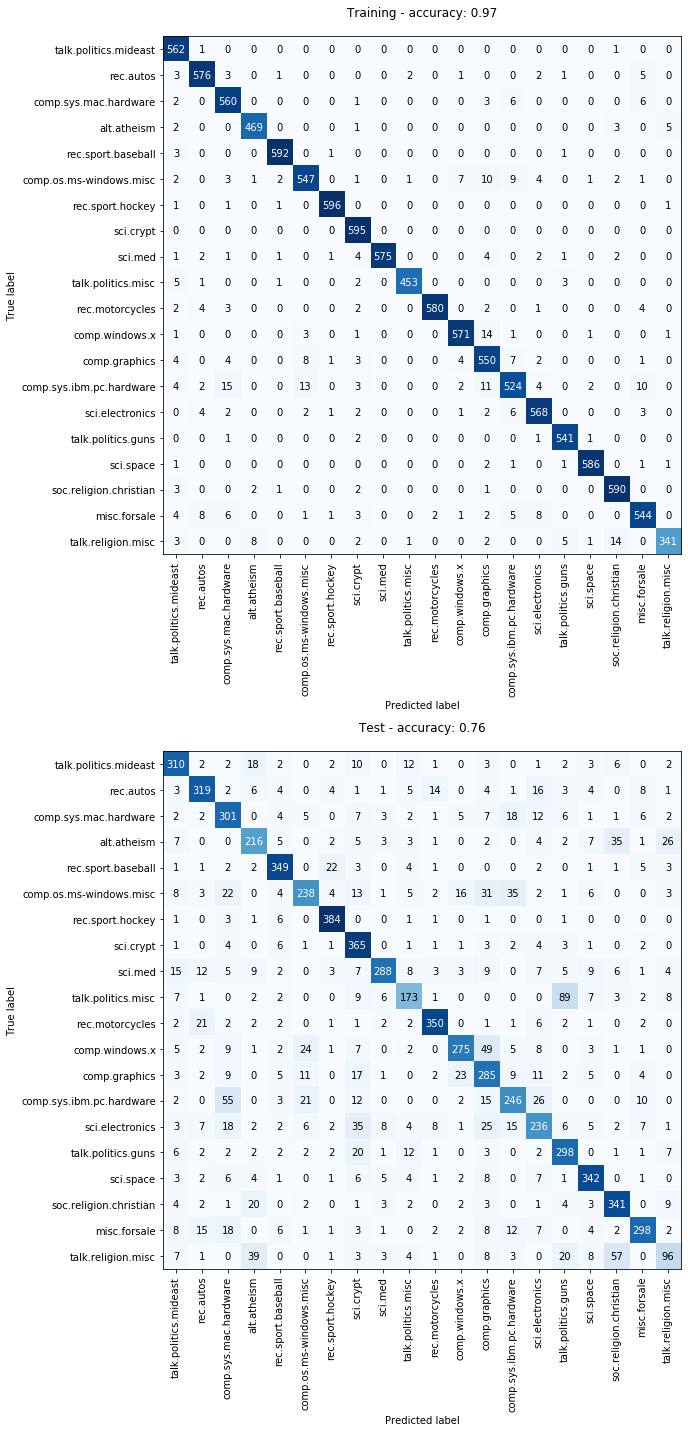

In [57]:
plot_model_performance(model, X_train, y_train, X_test, y_test, label_names)

# Word2Vec

In [58]:
# prepare data for gensim
# data needs to be presented as a list of list of words
train_sentences = []
for review in train_data[2]:
    train_sentences.append(review.split(' '))

In [59]:
from gensim.models.word2vec import Word2Vec

w2v_model = Word2Vec(train_sentences, size=100, window=10, min_count=10, sample=1e-3, workers=6)
w2v_model.init_sims(replace=True)

In [60]:
def featurize_w2v(w2v_model, sentences):
    f = np.zeros((len(sentences), w2v_model.vector_size))
    for i, s in enumerate(sentences):
        for w in s:
            try:
                vec = w2v_model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

In [61]:
X_train_w2v = featurize_w2v(w2v_model, train_sentences)

/Users/koen/Documents/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [62]:
test_sentences = []
for review in test_data[2]:
    test_sentences.append(review.split(' '))
X_test_w2v = featurize_w2v(w2v_model, test_sentences)

/Users/koen/Documents/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [63]:
from sklearn.ensemble import RandomForestClassifier

# create random index
idx = np.arange(len(train_data[1]), dtype=np.int)
np.random.shuffle(idx)

# Initialize a Random Forest classifier with 100 trees
model = RandomForestClassifier(n_estimators = 100, n_jobs=-1) 
model = model.fit( X_train_w2v[idx], np.array(train_data[1])[idx] )

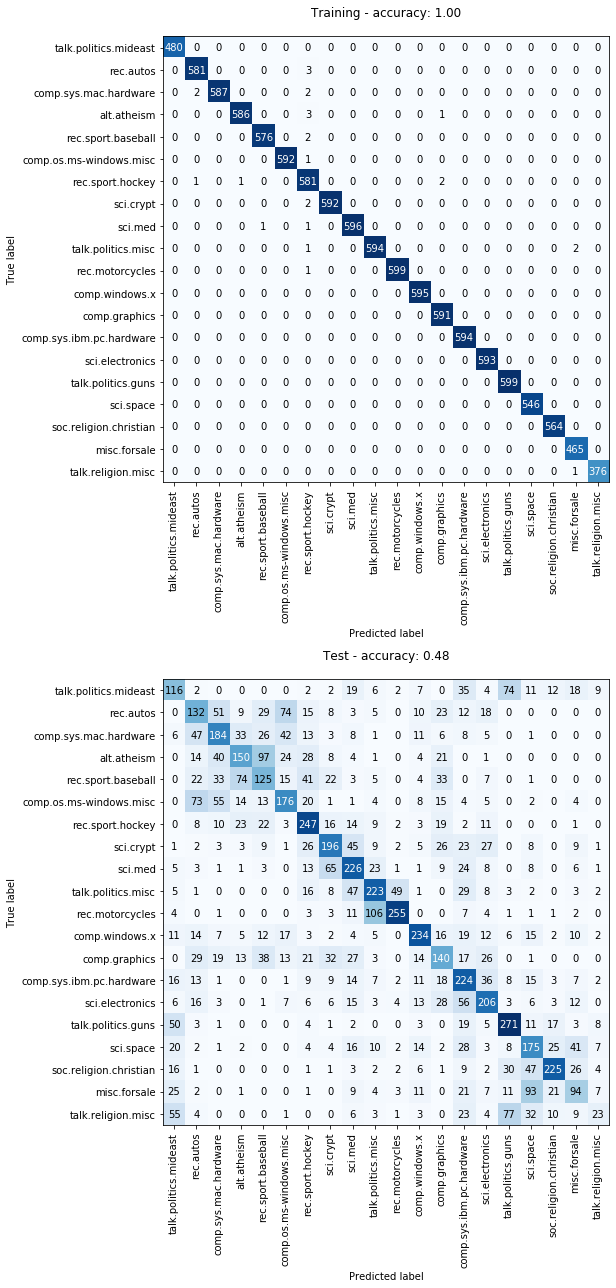

In [64]:
plot_model_performance(model, X_train_w2v, np.array(train_data[1]), X_test_w2v, np.array(test_data[1]), label_names, figsize=(14,18))

# How to continue from here?

You can practise the learned skills using other datasets. There are several datasets online available that could be used for this, including:

- [Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)
- [Yelp reviews](https://www.yelp.com/dataset)
- [50 machines learning datasets for NLP](https://blog.cambridgespark.com/50-free-machine-learning-datasets-natural-language-processing-d88fb9c5c8da)